# Ideas
0. ~Predicting UTIs~
1. ~[Predicting re-admission](https://jamanetwork.com/journals/jama/fullarticle/1104511) 🙅🏻‍♂️ (Only Admit Year is provided)~
2. Predicting length of stay [[1]](https://www.hindawi.com/journals/jhe/2016/7035463/tab3/) [[2]](https://towardsdatascience.com/predicting-hospital-length-of-stay-at-time-of-admission-55dfdfe69598)
3. ~Predicting opioid use disorders based on post-surgery opioid prescriptions~

# Features to Experiment With
* Encounter
    * HospID
    * Payer_Type
* Demographics
    * Sex
    * Race1
* Diagnoses
    * I10      Essential (primary) hypertension - 3336
    * E78.5    Hyperlipidemia, unspecified - 3194
    * E11.9    Type 2 diabetes mellitus without complications - 963
    * I25.10   Athscl heart disease of native coronary artery w/o ang pctrs - 1439
    * J44.9    Chronic obstructive pulmonary disease, unspecified - 818
    * I12.9    Hypertensive chronic kidney disease w stg 1-4/unsp chr kdny - 560
    * Y83.8    Oth surgical procedures cause abn react/compl, w/o misadvnt - 492
    * A41.9    Sepsis, unspecified organism - 480

In [1]:
import psycopg2
import pandas as pd
import numpy as np
from sqlalchemy import create_engine

import json

import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
with open('config.json') as file:
    config = json.load(file)
    host = config['host']
    database = config['database']
    user = config['user']
    password = config['password']

In [3]:
engine = create_engine(f'postgresql://{user}:{password}@{host}:5432/{database}')

In [14]:
query = """
SELECT * FROM ms_encounters WHERE "EncType"='I'
"""

inpatient_encounters = pd.read_sql_query(query, engine)

In [16]:
inpatient_encounters.head()

,index,HospID,PtID,AdmtID,Admit_Year,Rel_Discharge_Day,Reason_For_Visit_Txt,Pat_ZIP_Masked,EncType,DRG,DRG_Type,HCA_Adm_Src,HCA_Adm_Class,HCA_Disch_Dispo,HCA_Disch_Dispo_Desc,Age_Years,Payer_Type
0,1,27400,137172158,190599000401972101,2019,7,WOUND INFECTION LEFT LEG,800,I,478,10,1,A,6,Discharged/transferred to Home Under Care of O...,60,BLUE CROSS/COST
1,4,27300,137094979,190459000158965684,2019,2,DEVERTICULITIS,802,I,331,10,1,A,1,Discharged to Home or Self Care (Routine Disch...,69,MANAGED CARE MEDICARE
2,6,27450,226440736,190469000186984828,2019,5,PNEUMOTHORAX,802,I,243,10,1,A,1,Discharged to Home or Self Care (Routine Disch...,999,MEDICARE - PPS
3,7,27400,136514109,190089000208952415,2019,3,THROMBECTOMY,800,I,253,10,1,A,1,Discharged to Home or Self Care (Routine Disch...,64,PPO
4,8,27100,138268613,190499000159892880,2019,43,"18% TBSA BURNS TO RT THIGH,LOWERGROIN,LTFOOT,BUTT",800,I,928,10,1,A,62,Discharged/transferred to an Inpatient Rehabil...,50,MEDICARE - PPS


In [17]:
query = """
SELECT "Rel_Discharge_Day" FROM ms_encounters WHERE "EncType"='I'
"""

hist_los = pd.read_sql_query(query, engine)

(array([9.739e+03, 6.800e+01, 1.000e+01, 7.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([  0. ,  45.2,  90.4, 135.6, 180.8, 226. , 271.2, 316.4, 361.6,
        406.8, 452. ]),
 <a list of 10 Patch objects>)

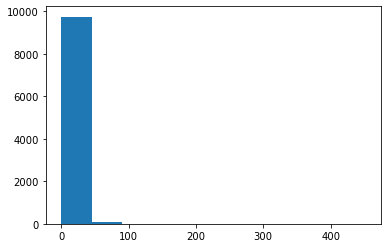

In [22]:
plt.hist(hist_los['Rel_Discharge_Day'])

(array([9.296e+03, 3.560e+02, 1.010e+02, 3.000e+01, 1.800e+01, 1.100e+01,
        5.000e+00, 0.000e+00, 3.000e+00, 4.000e+00]),
 array([  0. ,  16.8,  33.6,  50.4,  67.2,  84. , 100.8, 117.6, 134.4,
        151.2, 168. ]),
 <a list of 10 Patch objects>)

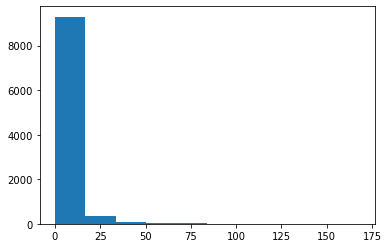

In [24]:
plt.hist(hist_los[hist_los['Rel_Discharge_Day'] < 300]['Rel_Discharge_Day'])

In [59]:
query = """
SELECT "Rel_Discharge_Day" as "Length of Stay", COUNT("Rel_Discharge_Day") AS Count
FROM ms_encounters
WHERE "EncType"='I'
GROUP BY "Rel_Discharge_Day"
"""

length_of_stay = pd.read_sql_query(query, engine)
length_of_stay.sort_values('Length of Stay')

,Length of Stay,count
15,0,238
95,1,1872
46,2,1856
89,3,1659
12,4,985
...,...,...
81,159,1
50,166,1
31,168,1
60,365,1


(array([ 238., 1872., 1856., 1659.,  985.,  626.,  487.,  369.,  277.,
         236.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

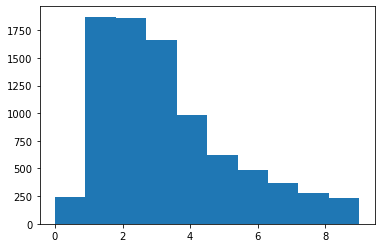

In [28]:
plt.hist(hist_los[hist_los['Rel_Discharge_Day'] < 10]['Rel_Discharge_Day'], 10)

In [60]:
query = """
SELECT enc."PtID", enc."HospID", enc."Rel_Discharge_Day", demo."Sex", demo."Race1"
FROM ms_encounters AS enc
INNER JOIN ms_demographicss as demo
ON enc."AdmtID"=demo."AdmtID"
where enc."EncType" = 'I'
"""

demographics = pd.read_sql_query(query, engine)

In [61]:
demographics.head()

,PtID,HospID,Rel_Discharge_Day,Sex,Race1
0,136345589,27150,1,M,W
1,136918267,27100,3,F,W
2,136344460,27150,2,M,W
3,136354795,31608,4,F,W
4,136893443,27300,3,F,W


(array([ 257., 6223., 1426.,    0.,    0.,    0.,    0.,    0.,    0.,
        1922.]),
 array([26330. , 26857.8, 27385.6, 27913.4, 28441.2, 28969. , 29496.8,
        30024.6, 30552.4, 31080.2, 31608. ]),
 <a list of 10 Patch objects>)

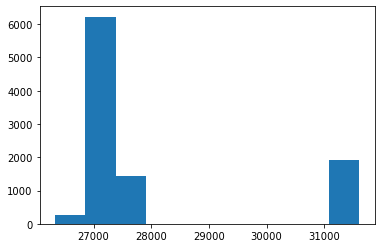

In [62]:
plt.hist(demographics['HospID'])

(array([4.168e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 5.656e+03,
        0.000e+00, 0.000e+00, 0.000e+00, 4.000e+00]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

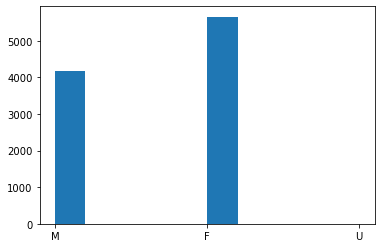

In [63]:
plt.hist(demographics['Sex'])

(array([7875.,  198.,  907.,    0.,  158.,  586.,    0.,   12.,   40.,
          52.]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <a list of 10 Patch objects>)

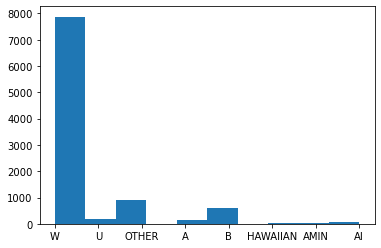

In [64]:
plt.hist(demographics['Race1'])

(array([2574., 3923.,   90., 2195.,   10.,  147.,  281.,  287.,  168.,
         151.]),
 array([ 0. ,  1.6,  3.2,  4.8,  6.4,  8. ,  9.6, 11.2, 12.8, 14.4, 16. ]),
 <a list of 10 Patch objects>)

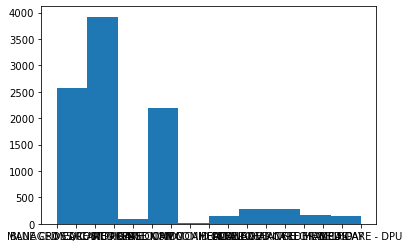

In [66]:
plt.hist(inpatient_encounters['Payer_Type'])

In [74]:
query = """
select dx."OrigDX", dx."DxDesc" 
from ms_encounters as enc
inner join ms_diagnosis as dx
on enc."AdmtID" = dx."AdmtID" 
where enc."EncType" ='I'
and dx."Padmit" = 'Y'
"""

diagnoses = pd.read_sql_query(query, engine)

In [77]:
diagnoses.value_counts()[:50]

OrigDX    DxDesc                                                      
I10       Essential (primary) hypertension                                3336
E78.5     Hyperlipidemia, unspecified                                     3194
K21.9     Gastro-esophageal reflux disease without esophagitis            2513
F32.9     Major depressive disorder, single episode, unspecified          1921
E03.9     Hypothyroidism, unspecified                                     1647
F41.9     Anxiety disorder, unspecified                                   1605
I25.10    Athscl heart disease of native coronary artery w/o ang pctrs    1439
G47.33    Obstructive sleep apnea (adult) (pediatric)                     1283
G89.29    Other chronic pain                                              1197
N17.9     Acute kidney failure, unspecified                               1172
D64.9     Anemia, unspecified                                             1079
M19.90    Unspecified osteoarthritis, unspecified site      

In [78]:
num_of_admissions = len(inpatient_encounters['AdmtID'].unique())
num_of_admissions

9826

In [116]:
hosp_id_chunk_one = inpatient_encounters[inpatient_encounters['Rel_Discharge_Day'] < 3]['HospID'].astype('str')
hosp_id_chunk_two = inpatient_encounters[(inpatient_encounters['Rel_Discharge_Day'] >= 3)
                                         & (inpatient_encounters['Rel_Discharge_Day'] < 10)]['HospID'].astype('str')
hosp_id_chunk_three = inpatient_encounters[inpatient_encounters['Rel_Discharge_Day'] >= 10]['HospID'].astype('str')
number_of_ids = len(hosp_id_chunk_one.unique())

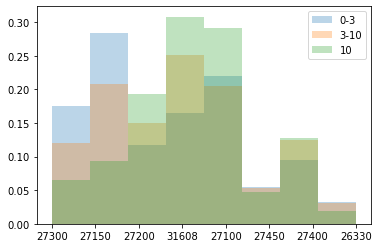

In [130]:
plt.hist(hosp_id_chunk_one, number_of_ids, density=True, alpha = 0.3, label='0-3')
plt.hist(hosp_id_chunk_two, number_of_ids, density=True, alpha = 0.3, label='3-10')
plt.hist(hosp_id_chunk_three, number_of_ids, density=True, alpha = 0.3, label='10')
plt.legend(loc='upper right')

In [124]:
query = """
select  me."Rel_Discharge_Day", md."Sex" , md."Race1" 
from ms_encounters me 
inner join ms_demographicss md 
on me."AdmtID" = md."AdmtID" 
where me."EncType" = 'I'
"""

demographic_features = pd.read_sql_query(query, engine)

In [126]:
def chunk_features(df):
    chunk_one = df[df['Rel_Discharge_Day'] < 3]
    chunk_two = df[(df['Rel_Discharge_Day'] >= 3) & (df['Rel_Discharge_Day'] < 10)]
    chunk_three = df[df['Rel_Discharge_Day'] >= 10]
    
    return (chunk_one, chunk_two, chunk_three)

In [127]:
demographic_features_chunk_one, demographic_features_chunk_two, demographic_features_chunk_three = chunk_features(demographic_features)

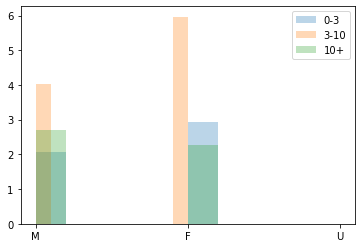

In [131]:
plt.hist(demographic_features_chunk_one['Sex'], density=True, alpha=0.3, label='0-3')
plt.hist(demographic_features_chunk_two['Sex'], density=True, alpha=0.3, label='3-10')
plt.hist(demographic_features_chunk_three['Sex'], density=True, alpha=0.3, label='10+')
plt.legend()

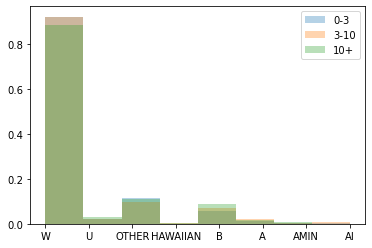

In [151]:
chunk_and_plot(demographic_features, 'Race1')

In [133]:
query = """
select  me."Rel_Discharge_Day", me."Payer_Type" 
from ms_encounters me 
where me."EncType" = 'I'
"""

payer_types = pd.read_sql_query(query, engine)

In [135]:
payers_one, payers_two, payers_three = chunk_features(payer_types)

In [166]:
def plot_overlapping_histogram(df_one, df_two, df_three, column):
    bins = max(len(df_one[column].unique()), len(df_two[column].unique()), len(df_three[column].unique()))
    plt.hist(df_one[column], bins, density=True, alpha=0.33, label='0-3')
    plt.hist(df_two[column], bins, density=True, alpha=0.33, label='3-10')
    plt.hist(df_three[column], bins, density=True, alpha=0.33, label='10+')
    plt.title(column)
    plt.legend()
    plt.show()

In [167]:
def chunk_and_plot(df, column):
    chunk_one, chunk_two, chunk_three = chunk_features(df)
    plot_overlapping_histogram(chunk_one, chunk_two, chunk_three, column)

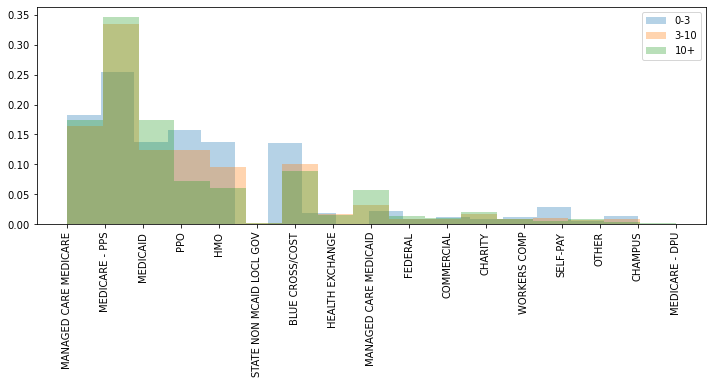

In [150]:
plt.figure(figsize=(12, 4))
plt.xticks(rotation=90)
chunk_and_plot(payer_types, 'Payer_Type')

In [153]:
query = """
select  me."Rel_Discharge_Day", md."OrigDX"
from ms_encounters me 
join ms_diagnosis md
on me."AdmtID" = md."AdmtID" 
where me."EncType" = 'I'
"""

dx = pd.read_sql_query(query, engine)

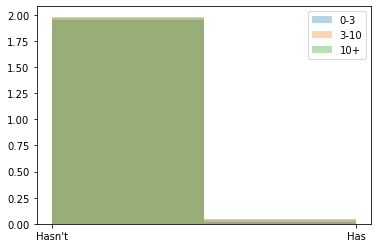

In [160]:
def mark_diagnosis(row, diagnosis):
    if row['OrigDX'] == diagnosis:
        return 'Has'
    else:
        return "Hasn't"

dx['has_hypertension'] = dx.apply(lambda row: mark_diagnosis(row, 'I10'), axis=1)
chunk_and_plot(dx, 'has_hypertension')

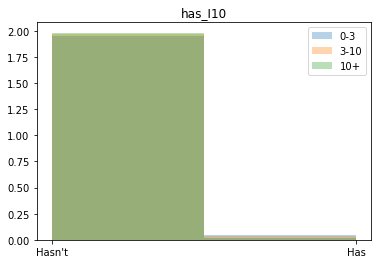

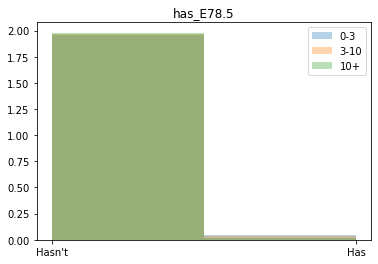

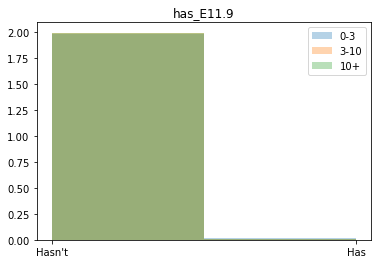

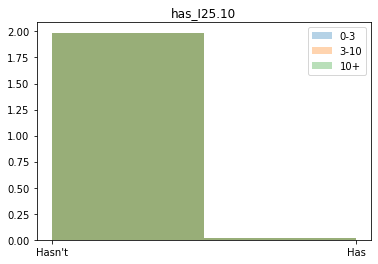

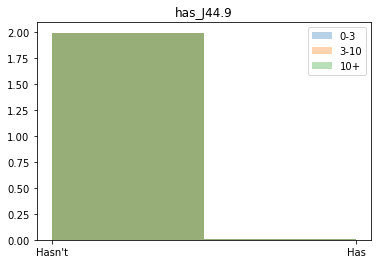

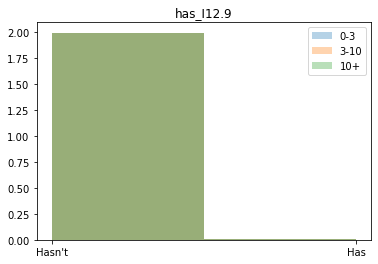

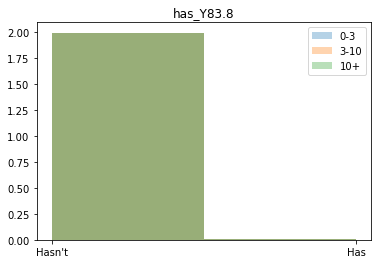

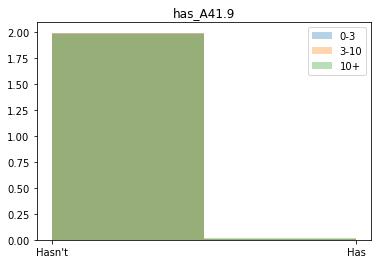

In [170]:
diagnoses = ['I10', 'E78.5', 'E11.9', 'I25.10', 'J44.9', 'I12.9', 'Y83.8', 'A41.9']

for diagnosis in diagnoses:
    label = f"has_{diagnosis}"
    dx[label] = dx.apply(lambda row: mark_diagnosis(row,  diagnosis), axis=1)
    chunk_and_plot(dx, label)